In [16]:
#%matplotlib widget
import pandas as pd
import random
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [15, 6]
from collections import defaultdict
import numpy as np

---
Functions that we're going to need:

In [17]:
##################################################################################
def sample_treebanks(original, seed, mode): #Input: A dataframe with  UD treebanks (columns: target treebank rows: transfer treebank), 
                                                #A random seed
                                            #Ouput: A list with a sample of treebanks (one per language)
    UDs= defaultdict(list)
    if mode =="columns":
        treebanks=original.columns
    else:
        treebanks=original.index
    
    for col in treebanks:  #All languages treebanks (columns)
        tmplist=[]
        x = col.split("UD_")[1].split("-")
        languagename=x[0] #Language Name
        #print (languagename, col)
        tmplist.append(col)
        #Create a Dictionary languagename:(treebank1, treebank2, ...)
        if languagename not in UDs:
            UDs[languagename]=tmplist
        else:
            UDs[languagename].append(col)
    #UDs contains each languagename and the associated treebanks
    
    ####Random sampling:#####
    random.seed(a=seed)

    #Foreach key (language name) randomly select just one treebank:  if array greater than 1, sample, assign to new dict
    UDs_sampled= defaultdict(list)  #UDs_sampled contains each languagename and the randomly selected treebank
    for key, value in UDs.items() :
        if len(value)>1: #only for Languages with more than one UD
            #print (key, value)
            randomtreebank=random.choice(value)
            UDs_sampled[key]=randomtreebank
        else:
            UDs_sampled[key]=value[0] #Languages with only one treebank, remain the same. 

    #print(UDs_sampled)

    sample=list(UDs_sampled.values())  #The random sample
    return sample

---
- Preparing URIEL vectors:

In [18]:
l2v = pd.read_csv("../data/l2v.csv",index_col=0)  #l2v vectors
iso = pd.read_csv("../data/iso.csv", index_col=0)  #iso csv:  UD, iso code
missingfeatures=pd.read_csv("../data/l2v_missing_feats_counts.csv", index_col=0)  #missingfeatures count

In [19]:
l2v

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
Treebank,,,,,,,,,,,,,,,,,,,,,
UD_Afrikaans-AfriBooms,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Ancient_Greek-PROIEL,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Ancient_Greek-Perseus,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Arabic-PADT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
UD_Armenian-ArmTDP,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UD_Uyghur-UDT,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
UD_Vietnamese-VTB,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Welsh-CCG,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


- Sampling just one treebank per language:

In [20]:
l2v=l2v.loc[l2v.index.intersection(iso.index)]  #Intersection between what is available in ISO and the set that we use in our experiments
#No repetitions:
randomsample=sample_treebanks(l2v, 1, "rows")
l2v=l2v.loc[l2v.index.intersection(randomsample)]
#Drop Armenian since in l2v is the same vector associated with two UDs:
l2v=l2v.drop(["UD_Armenian-ArmTDP"])
iso=iso.loc[iso.index.intersection(l2v.index)]  #set of UDs that we use in our experiments
l2v

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
Treebank,,,,,,,,,,,,,,,,,,,,,
UD_Afrikaans-AfriBooms,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Ancient_Greek-PROIEL,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Arabic-PADT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
UD_Basque-BDT,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
UD_Belarusian-HSE,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UD_Uyghur-UDT,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
UD_Vietnamese-VTB,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
UD_Welsh-CCG,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0



- Missing  L2V features per language code:

In [21]:
aux=pd.merge(iso, missingfeatures, on='iso', how="left").set_index('iso')
aux  # we're going to use this for colors of missing features
colors=aux["count"].tolist()
aux


,count
iso,
afr,66
grc,70
arb,37
eus,18
bel,70
...,...
uig,45
vie,10
cym,22



- Applying PCA and plotting:

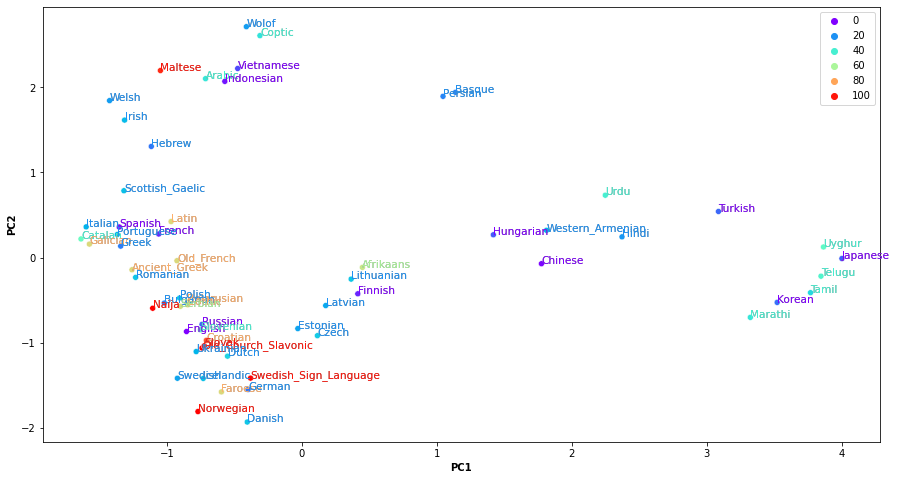

In [22]:

#mpl.style.use("default")

#We apply PCA to L2V (URIEL) vectors:
pca=PCA(n_components=2)
pca.fit(l2v)
pca_data=pca.transform(l2v)

results_pca = pd.DataFrame(pca_data)
results_pca.rename(columns={ 0 : 'x', 1 : 'y'}, inplace=True)
#################################

#We plot the resulting vectors (reduced to two dimensions)


fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(111)

xs = results_pca['x']
ys = results_pca['y']

labels=l2v.index

labels_filtered = [w.replace('UD_', '') for w in labels] #only language and UD
labels_filtered2 = [w.split("-")[0] for w in labels_filtered] #only print language


#cbar=plt.colorbar(img, fraction=0.026, pad=0.04)

#plt.savefig("../results/PCAplots/l2v_PCA2_missingfeatures.png")
    
#Draw by color, features available


sns.scatterplot(x="x", y="y", hue=colors,
                data=results_pca, palette='rainbow')

ax.set_xlabel('PC1',fontdict=dict(weight='bold'))
ax.set_ylabel('PC2',fontdict=dict(weight='bold'))

for x, y, label, color in zip(xs, ys, labels_filtered2, colors):
    ax.text(x, y,  label, weight="book", color="gray", fontsize=10.5)
    
    if (color<16):
        ax.text(x, y,  label, weight="book", color="#8000ff", fontsize=10.5)
    if (color>=16 and color<33):
        ax.text(x, y,  label, weight="book", color="#1e91f3", fontsize=10.5)
    if (color>=33 and color<60):
        ax.text(x, y,  label, weight="book", color="#47efd1", fontsize=10.5)
        
    if (color>=60 and color<70):
        ax.text(x, y,  label, weight="book", color="#abf69b", fontsize=10.5)
        
    if (color>=70 and color<93):
        ax.text(x, y,  label, weight="book", color="#ffaf6a", fontsize=10.5)
        
    if (color>=93):
        ax.text(x, y,  label, weight="book", color="#ff160b", fontsize=10.5)